# Nonlinear Poisson equation

Source: Fenics demo [nonlinear Poisson equation](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/nonlinear-poisson/demo_nonlinear-poisson.py.html).

Next, we consider a nonlinear version of the Poisson equation to see how we can solve nonlinear variational problems in Fenics. The domain is a two-dimensional square with two circular holes as shown below:

<img src="nonlinear_poisson_setup.png" style="width:400px;">

We fix $L = 0.8$ and $W = 1.2$. 

Consider a two-dimension domain $\Omega = (0,1)^2 - B(\boldsymbol{x}_1, r_1) - B(\boldsymbol{x}_2, r_2)$ shown in the figure above, where $B(\boldsymbol{x}, r)$ is the 2-d ball of radius $r$ centered $\boldsymbol{x}$. Here, $\boldsymbol{x}_1 = (0.2L, 0.8W), \boldsymbol{x}_2 = (0.7L, 0.3W), r_1 = 0.1L, r_2 = 0.2L$. 

Let 
\begin{equation}
\Gamma_{in} := \partial B(\boldsymbol{x}_1, r_1) \cup \partial B(\boldsymbol{x}_2, r_2), 
\end{equation}
where $\partial B(\boldsymbol{x}, r)$ denotes the boundary of ball $B(\boldsymbol{x}, r)$. Further let 
\begin{equation}
\Gamma_{out} = \partial \Omega - \Gamma_{in} = \{(x, y): x \in \{0, L\}, y \in [0, W]\} \cup \{(x, y): y \in \{0, W\}, x \in [0, L]\}. 
\end{equation}. 

We consider the following nonlinear Poisson equation:
\begin{equation}
-div (\kappa (1+u^2) grad (u(x, y))) = f(x, y) \qquad \text{for } \qquad (x,y) \in \Omega,
\end{equation}
with the source $f$ given by
\begin{equation}
f(x, y) = x \sin(4y)
\end{equation}
and boundary conditions given by
\begin{align}
u &= 0 \qquad \text{ on } \qquad \Gamma_{in} \\
\kappa (1+ u^2) \nabla u \cdot n &= g \qquad \text{ on } \qquad \Gamma_{out}
\end{align}
with $g(x,y) = (1 - x/L)^2 + (y/W)^2 - (1 - x/L)^2 (y/W)^2$. Here, $\kappa = 0.75$ is the diffusivity constant. 

## Variational formulation
Let $V$ be the suitable function space then the variational problem associated to the above PDE reads: find $u\in V$ such that
\begin{equation}
\underbrace{\int_{\Omega} \kappa (1 + u^2) \nabla u \cdot \nabla v dx}_{=: a(u;v)} = \underbrace{\int_{\Omega} f v dx + \int_{\Gamma_{out}} g v ds}_{=:l(v)} \qquad \text{for } \qquad v \in V.
\end{equation}
In the above $a(u;v)$ is the semilinear form and $l(v)$ is the linear form. Residual of the problem $R(u;v)$ is given by
\begin{equation}
R(u; v) := a(u; v) - l(v).
\end{equation}
Thus the problem can be written as
\begin{equation}
R(u; v) = 0 \qquad \qquad \forall v \in V .
\end{equation}


## Finite element approximation
Let $V_h$ be the finite element function space. Then the finite element approximation reads: find $u_h \in V_h$ such that
\begin{equation}
R(u_h; v_h) = 0 \qquad \text{for all } \qquad v_h \in V_h.
\end{equation}

### Newton's iteration to solve the nonlinear problem
Let $u_k$ is the solution at the $k$th step and we are interested in $\delta u$ such that $u_k + \delta u \approx u$, $u$ being the exact solution such that $R(u; v) = 0$ for all $v$. Suppose $u = u_k + \delta u$. Then Taylor series expansion of $R(u; v)$ around $u_k$ is given by
\begin{equation}
R(u_k + \delta u; v) = R(u_k; v) + \delta_u R(u_k; \delta u, v) + O(||\delta u||^2),
\end{equation}
where $\delta_u R(u; q, v)$ is the variational (G\:ateaux) derivative of $R$ with respect to the first argument and is defined as
\begin{equation}
\delta_u R(u; q, v) = \lim_{\eta \to 0} \frac{R(u + \eta q; v) - R(u; v)}{\eta} = \int_{\Omega} \kappa \left[ 2 u q \nabla u \cdot \nabla v + (1+u^2) \nabla q \cdot \nabla v \right] dx.
\end{equation}

Now, setting $R(u_k + \delta u; v) \approx R(u_k; v) + \delta_u R(u_k; \delta u, v) = 0$ gives the equation for the increment $\delta u$ as follows: Given $u_k$, find $\delta u$ such that
\begin{equation}
\delta_u R(u_k; \delta u, v) = - R(u_k; v) \qquad \qquad \text{for all }\quad v\in V.  
\end{equation}

> Because of homogeneous Dirichlet boundary condition on $\Gamma_{in}$, trial function $u$, increment/variation function $\delta u$, and test function $v$ all belong to the same function space $V$. If nonzero Dirichlet boundary condition was specified then trial function will satisfy the nonzero Dirichlet boundary condition while the variation and test fucntion will satisfy homogeneous Dirichlet boundary condition. 

## Fenics implementation
We first import the dolfin package.

In [14]:
# dolfin includes fenics
import dolfin as dl

# for plotting
import matplotlib.pyplot as plt 

### Load mesh
In this case, we create the mesh using `gmsh`, convert `.msh` file into `.xdmf`, and load it in Fenics. Mesh files are in folder [../meshing/rectangle_with_two_holes/](../meshing/rectangle_with_two_holes/) (See file [../meshing/create_mesh.ipynb](../meshing/create_mesh.ipynb) for details about creating this mesh). 

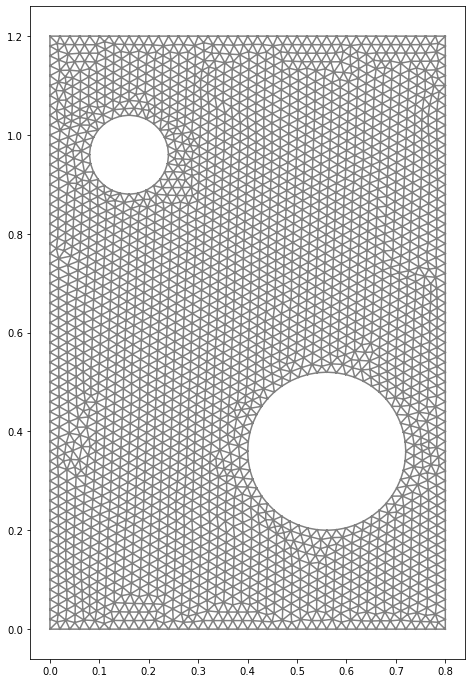

In [15]:
# geometry details that are used later also
omega_L = 0.8
omega_W = 1.2
hole_x1 = [0.2*omega_L, 0.8*omega_W]
hole_x2 = [0.7*omega_L, 0.3*omega_W]
hole_r1, hole_r2 = 0.1*omega_L, 0.2*omega_L

mesh = dl.Mesh()
mesh_fname = '../meshing/rectangle_with_two_holes/mesh_h_0.020'
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(8,12))
dl.plot(mesh)

plt.show()

Create function space:

In [16]:
# specify order of interpolation
p_order = 2

# create FE function space
V = dl.FunctionSpace(mesh, "Lagrange", p_order) # or dl.FunctionSpace(mesh, "P", p_order)

### Define boundaries of the domain for boundary conditions

In [17]:
# Define inner and outer boundaries
def outer_bdry(x, on_boundary):
    return (   x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS or 
               x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS
           ) and on_boundary
    
def hole1(x, on_boundary): 
    return (    dl.near(x[0], hole_x1[0], hole_r1 + 0.01) and 
                dl.near(x[1], hole_x1[1], hole_r1 + 0.01) \
           ) and on_boundary

def hole2(x, on_boundary):
    return (    dl.near(x[0], hole_x2[0], hole_r2 + 0.01) and 
                dl.near(x[1], hole_x2[1], hole_r2 + 0.01) \
           ) and on_boundary

def inner_bdry(x, on_boundary):
    # identiy points close to the boundaries of two holes
    return hole1(x, on_boundary) or hole2(x, on_boundary)

Next, define surface measure for integration of neumann boundary condition over $\Gamma_{out}$

In [18]:
# create one dimension lower mesh, i.e., mesh consisting of edges (in 2-d domain) 
# (for 3-d, it will be mesh consisting of faces of elements)
# arg1: type of value of mesh function (integer, double, bool, etc.)
# arg2: mesh
# arg3: dimension of the output mesh (here it is 1 as we want list of edges)
facets = dl.MeshFunction("size_t", mesh, 1)

# now mark the edges that coincide with the horizontal edges of the domain
# note we use `outer_bdry` in below
dl.AutoSubDomain(outer_bdry).mark(facets, 1)

# create surface measure associated with the horizontal edges
ds = dl.Measure("ds", subdomain_data=facets)

Now, create Dirichlet boundary condition object

In [19]:
u_bdr = dl.Constant(0.0) # use dolfin in-built Constant function

# now actually create boundary condition 
# arg1: function space, arg2: value of boundary condition, arg3: boundary domain
u_bc = dl.DirichletBC(V, u_bdr, inner_bdry)

Now, create function $g(x,y) = \sin(5x)$ for Neumann boundary condition

In [26]:
# degree specifies interpolation order when interpolating this function on to the mesh
g = dl.Expression("pow(1 - x[0]/omega_L, 2) + pow(x[1]/omega_W, 2) \
                    - pow(1 - x[0]/omega_L, 2)*pow(x[1]/omega_W, 2)", \
                  degree=2, \
                  omega_L = omega_L, \
                  omega_W = omega_W)

## Method 1: Use Fenics in-built Newton solver for nonlinear variational equations
Once the residual $R(u;v)$ is defined, we can directly solve $R(u;v) = 0$ in Fenics. Fenics will internally take care of computing variational derivative of $R$ and use Newton step. 

### Define residual

In [27]:
# trial and test function (Here we use dl.Function)
u = dl.Function(V, name = 'u')
v = dl.TestFunction(V)

# forcing term
f = dl.Expression("x[0]*sin(x[1])", degree=2)

# diffusivity coefficient
kappa = dl.Constant(0.75)

# semilinear form
a = kappa * dl.inner((1 + u**2)*dl.grad(u), dl.grad(v))*dl.dx

# linear form
l = f*v*dl.dx + g*v*ds

# residual
R = a - l

### Solve the problem R = 0

In [28]:
# Compute solution 
# arg1: nonlinear variational equation
# arg2: solution u
# arg3: Dirichlet boundary condition
# arg4: Solver parameters
dl.solve(R == 0, u, u_bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.634e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 9.816e-02 (tol = 1.000e-10) r (rel) = 6.006e-01 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 1.194e-02 (tol = 1.000e-10) r (rel) = 7.302e-02 (tol = 1.000e-06)
  Newton iteration 3: r (abs) = 2.275e-04 (tol = 1.000e-10) r (rel) = 1.392e-03 (tol = 1.000e-06)
  Newton iteration 4: r (abs) = 7.488e-08 (tol = 1.000e-10) r (rel) = 4.582e-07 (tol = 1.000e-06)
  Newton solver finished in 4 iterations and 4 linear solver iterations.


Save solution and plot result

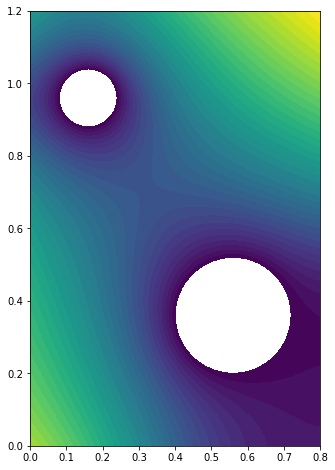

In [29]:
# Save solution in VTK format
file = dl.File("fwd_result/nonlinear_poisson_equation.pvd")
file << u

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

### Plotting in paraview
- load file `poisson_equation.pvd` in paraview
- apply `warp by scalar` filter
- click on `2D` in view panel to change view to `3D`

The result looks as follows

<img src="nonlinear_poisson_equation_result.png" style="width:600px;">

## Method 2: Create our own Newton solver

We create our own Newton solver which basically solves $$\delta_u R(u_k; \delta u_k, v) = - R(u_k;v)$$ for increment $\delta u_k$ given $u_k$ in every iteration $k$. 